In [2]:
import pandas as pd
data=pd.read_csv("dataset.csv")
data.head

<bound method NDFrame.head of       Age Attrition     BusinessTravel  DailyRate              Department  \
0      41       Yes      Travel_Rarely       1102                   Sales   
1      49        No  Travel_Frequently        279  Research & Development   
2      37       Yes      Travel_Rarely       1373  Research & Development   
3      33        No  Travel_Frequently       1392  Research & Development   
4      27        No      Travel_Rarely        591  Research & Development   
...   ...       ...                ...        ...                     ...   
1465   36        No  Travel_Frequently        884  Research & Development   
1466   39        No      Travel_Rarely        613  Research & Development   
1467   27        No      Travel_Rarely        155  Research & Development   
1468   49        No  Travel_Frequently       1023                   Sales   
1469   34        No      Travel_Rarely        628  Research & Development   

      DistanceFromHome  Education EducationFi

In [3]:
data.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [4]:
data['Attrition'].value_counts()

Attrition
No     1233
Yes     237
Name: count, dtype: int64

<Axes: >

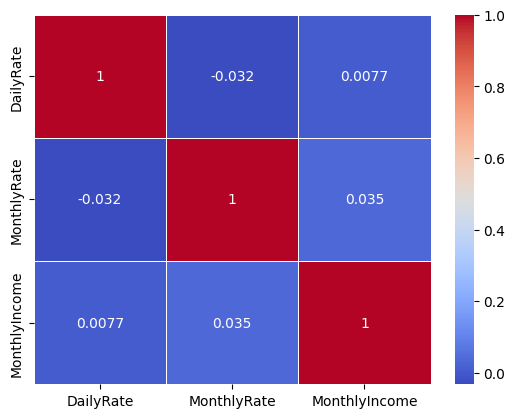

In [5]:
import seaborn as sb
income=data[['DailyRate','MonthlyRate','MonthlyIncome']]
corre=income.corr()
sb.heatmap(corre,annot=True,cmap='coolwarm',linewidth=0.5)

In [1]:
import kfp
import kfp.components as comp
import requests
import kfp.dsl as dsl
from kfp.dsl import pipeline, component,Dataset,Output,Input,Model
@component(
    base_image='python:3.13.1',
    packages_to_install=['pandas==2.2.3', 'numpy==2.2.0']
)
def prepare_data(output_data: Output[Dataset]):
    print("Inside prepare data component")
    data = pd.read_csv("https://raw.githubusercontent.com/AnanthMAthreya/DT_pipeline/main/dataset.csv")
    data['Attrition']=data['Attrition'].map({"Yes":1,"No":0}).astype(int)
    data['BusinessTravel'] = data['BusinessTravel'].astype(str)
    data['BusinessTravel'] = data['BusinessTravel'].str.strip()
    data['BusinessTravel'] = data['BusinessTravel'].map(
    {'Non-travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})
    data['BusinessTravel'] = data['BusinessTravel'].fillna(0)
    data['Department']=data['Department'].map({'Sales':0, 'Research & Development':1, 'Human Resources':2}).astype(int)
    data['EducationField']=data['EducationField'].map({'Life Sciences':1,'Other':0,'Medical':2,'Marketing':3,'Technical Degree':4,'Human Resources':5}).astype(int)
    data['Gender']=data['Gender'].map({'Female':0, 'Male':1}).astype(int)
    data['JobRole']=data['JobRole'].map({'Sales Executive':0, 'Research Scientist':1, 'Laboratory Technician':2,
       'Manufacturing Director':3, 'Healthcare Representative':4, 'Manager':5,
       'Sales Representative':6, 'Research Director':7, 'Human Resources':8}).astype(int)
    data['MaritalStatus']=data['MaritalStatus'].map({'Single':0, 'Married':1, 'Divorced':2}).astype(int)
    data['OverTime']=data['OverTime'].map({'Yes':1,'No':0}).astype(int)
    data.to_csv(output_data.path, index=False)
    print('The prepared data is saved in final_data.csv artifact')



In [2]:
@component(base_image='python:3.13.1',packages_to_install=['pandas==2.2.3','numpy==2.2.0','scikit-learn==1.6.0'])
def train_test_split(input_data: Input[Dataset], output_train_data: Output[Dataset], output_test_data: Output[Dataset]):
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split as tts
    print("---- Inside train_test_split component ----")
    data=pd.read_csv(input_data.path)
    features=['Age','BusinessTravel','DailyRate', 'Department','DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome','MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears','TrainingTimesLastYear','WorkLifeBalance','YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion','YearsWithCurrManager']
    X=data[features]
    y=data['Attrition']
    X_train,X_test,y_train,y_test=tts(X,y,test_size=0.3,stratify=y,random_state=47)
    np.save(output_train_data.path + '/X_train.npy', X_train)
    np.save(output_train_data.path + '/y_train.npy', y_train)
    np.save(output_test_data.path + '/X_test.npy', X_test)
    np.save(output_test_data.path + '/y_test.npy', y_test)
    print("All the 4 parts have been saved")



In [3]:
@component(base_image='python:3.13.1',packages_to_install=['pandas==2.2.3','numpy==2.2.0','scikit-learn==1.6.0'])
def train_decision_tree(input_train_data: Input[Dataset], output_model: Output[Model]):
    import pandas as pd
    import numpy as np
    import pickle
    from sklearn import tree
    print("Inside decision-tree-classifier")
    X_train = np.load(input_train_data.path + '/X_train.npy', allow_pickle=True)
    y_train = np.load(input_train_data.path + '/y_train.npy', allow_pickle=True)
    model=tree.DecisionTreeClassifier(max_depth=3)
    model.fit(X_train,y_train)
    with open(output_model.path,'wb') as f:
        pickle.dump(model, f)
    print("The decision tree model is saved")



In [4]:
@component(base_image='python:3.13.1',packages_to_install=['pandas==2.2.3','numpy==2.2.0','scikit-learn==1.6.0'])
def get_metrics(input_train_data: Input[Dataset], input_test_data: Input[Dataset], input_model: Input[Model]):
    from sklearn.metrics import confusion_matrix as cm
    import numpy as np
    import pickle
    X_train = np.load(input_train_data.path + '/X_train.npy', allow_pickle=True)
    y_train = np.load(input_train_data.path + '/y_train.npy', allow_pickle=True)
    X_test = np.load(input_test_data.path + '/X_test.npy', allow_pickle=True)
    y_test = np.load(input_test_data.path + '/y_test.npy', allow_pickle=True)
    with open(input_model.path,'rb') as f:
        model = pickle.load(f)
    y_pred_train=model.predict(X_train)
    cm1=cm(y_train,y_pred_train)
    acc1=(cm1[0,0]+cm1[1,1])/sum([sum(i) for i in cm1])
    print("The train accuracy is ",acc1)
    y_pred_test=model.predict(X_test)
    cm2=cm(y_test,y_pred_test)
    acc2=(cm2[0,0]+cm2[1,1])/sum([sum(i) for i in cm2])
    print("The test accuracy is ",acc2)
    print("THe difference in the accuracies is ",abs(acc1-acc2))
    
    

In [5]:
@dsl.pipeline(
   name='Decision tree classifier Kubeflow Demo Pipeline',
   description='A sample pipeline that performs Decision tree classifier'
)
def dt_pipeline():
    prepare_data_task = prepare_data()
    train_test_split_task = train_test_split(input_data=prepare_data_task.outputs['output_data'])
    train_decision_tree_task = train_decision_tree(input_train_data=train_test_split_task.outputs['output_train_data'])
    get_metrics_task = get_metrics(
        input_train_data=train_test_split_task.outputs['output_train_data'],
        input_test_data=train_test_split_task.outputs['output_test_data'],
        input_model=train_decision_tree_task.outputs['output_model']
    )

In [6]:
kfp.compiler.Compiler().compile(
    pipeline_func=dt_pipeline,
    package_path='dt_pipeline1.yaml')

In [ ]:
from sklearn import tree
from sklearn.metrics import confusion_matrix as cm
import numpy as np
X_train=np.load('X_train.npy',allow_pickle=True)
y_train=np.load('y_train.npy',allow_pickle=True)
features=['Age','BusinessTravel','DailyRate', 'Department','DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome','MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears','TrainingTimesLastYear','WorkLifeBalance','YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion','YearsWithCurrManager']
model=tree.DecisionTreeClassifier(max_depth=3)
model.fit(X_train,y_train)
#print(tree.export_text(model, feature_names = features))
X_test=np.load('X_test.npy',allow_pickle=True)
y_test=np.load('y_test.npy',allow_pickle=True)
y_pred_train=model.predict(X_train)
cm1=cm(y_train,y_pred_train)
acc1=(cm1[0,0]+cm1[1,1])/sum([sum(i) for i in cm1])
print("The train accuracy is ",acc1)
y_pred_test=model.predict(X_test)
cm2=cm(y_test,y_pred_test)
acc2=(cm2[0,0]+cm2[1,1])/sum([sum(i) for i in cm2])
print("The test accuracy is ",acc2)
print("THe difference in the accuracies is ",abs(acc1-acc2))




The train accuracy is  0.8561710398445093
The test accuracy is  0.8390022675736961
THe difference in the accuracies is  0.01716877227081315
